<a href="https://colab.research.google.com/github/mohameddhameem/IBM-Machine-Learning/blob/master/Time%20Series%20Survival%20Analysis/Final%20Assignment/Assignment_TimeSeries_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sunspot Prediction with Time Series and Deep Learning


## Main objective

Our objective is to preidct SunSpots.

Sunspots are temporary phenomena on the Sun's photosphere that appear as spots darker than the surrounding areas. 

They are regions of reduced surface temperature caused by concentrations of magnetic field flux that inhibit convection.

## About Data Set

The Dataset is downloaded from Kaggle. REf - https://www.kaggle.com/datasets/robervalt/sunspots


Dataset contains contains sunspots on a monthly basis from 1749 until 2018. 

Sunspots usually appear in pairs of opposite magnetic polarity. 

Their number varies according to the approximately 11-year solar cycle.

<U>Column Description:</U>

* Index - Index column of the time series. We will use this for our modeling
* Date - Date of the observation(from 1749 to 2018). We will use this for our visualization
* Monthly Mean Total Sunspot Number - Monthly mean total sunspot for the date

In [1]:
!pip install -q pmdarima

     |████████████████████████████████| 1.4 MB 35.1 MB/s 
     |████████████████████████████████| 9.8 MB 60.8 MB/s 


In [2]:
!pip install -q fbprophet

In [3]:
# import all required libraries
import pandas as pd
import numpy as np
import tensorflow as tf
from datetime import datetime
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
import fbprophet
import pmdarima as pm
from statsmodels.tsa.arima_model import ARIMA
import seaborn as sns
import sys, os
import warnings
warnings.simplefilter(action='ignore')
print(f'Tensorflow version: {tf.__version__}')

Tensorflow version: 2.8.2


In [4]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv \
    -O /tmp/sunspots.csv

--2022-06-05 01:14:16--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.10.128, 142.251.12.128, 142.250.4.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.10.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70827 (69K) [application/octet-stream]
Saving to: ‘/tmp/sunspots.csv’

/tmp/sunspots.csv   100%[===================>]  69.17K  --.-KB/s    in 0s      

2022-06-05 01:14:17 (138 MB/s) - ‘/tmp/sunspots.csv’ saved [70827/70827]



In [5]:
# read Sunspots.csv into a pandas dataframe with date parse
df = pd.read_csv('/tmp/sunspots.csv',
                    parse_dates=['Date'])
df.tail(10)

,Unnamed: 0,Date,Monthly Mean Total Sunspot Number
3225,3225,2017-10-31,13.2
3226,3226,2017-11-30,5.7
3227,3227,2017-12-31,8.2
3228,3228,2018-01-31,6.8
3229,3229,2018-02-28,10.7
3230,3230,2018-03-31,2.5
3231,3231,2018-04-30,8.9
3232,3232,2018-05-31,13.2
3233,3233,2018-06-30,15.9
3234,3234,2018-07-31,1.6


In [6]:
# rename the Unnamed: 0 column to timestep
df.rename(columns={'Unnamed: 0': 'time_step',
                   'Monthly Mean Total Sunspot Number': 'sunspots'}, inplace=True)


## Exploratory Data Analysis

In [7]:
# Lets look at the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3235 entries, 0 to 3234
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   time_step  3235 non-null   int64         
 1   Date       3235 non-null   datetime64[ns]
 2   sunspots   3235 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 75.9 KB


In [8]:
# Check any missing values
df.isnull().sum()

time_step    0
Date         0
sunspots     0
dtype: int64

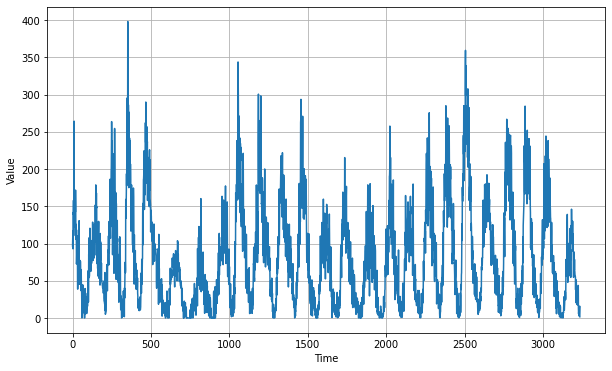

In [9]:
# Plot date vs sunspots
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)
series = np.array(df.sunspots)
time = np.array(df.time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

### Time Series Specific EDAs

We will check if the data is stationary or not.

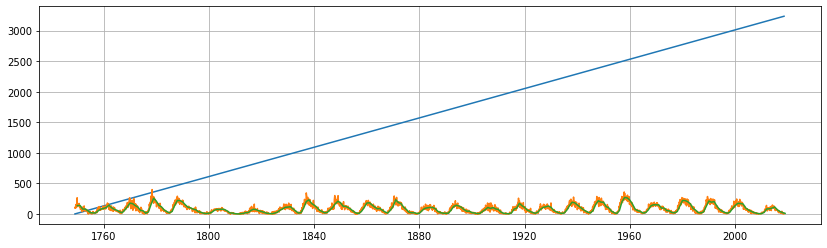

In [10]:
# resample to annual and plot each
plt.rcParams['figure.figsize'] = [14, 4]
df_full_timeseries = df.set_index('Date')
annual_sunspot = df_full_timeseries.resample('A').mean()

plt.plot(df_full_timeseries)
plt.plot(annual_sunspot.sunspots)
plt.grid(b=True);

In [11]:
# check if the data is stationary
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    #Determing rolling statistics
    df_timeseries = pd.DataFrame(timeseries)
    rolmean = df_timeseries.rolling(window=12).mean()
    rolstd = df_timeseries.rolling(window=12).std()
    #rolmean = pd.rolling_mean(timeseries, window=12)
    #rolstd = pd.rolling_std(timeseries, window=12)
    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

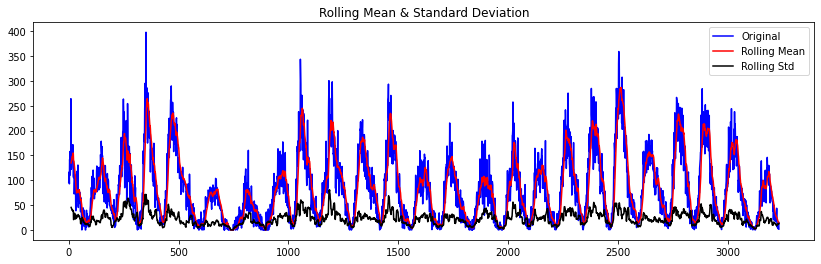

Results of Dickey-Fuller Test:
Test Statistic                -1.049256e+01
p-value                        1.137033e-18
#Lags Used                     2.800000e+01
Number of Observations Used    3.206000e+03
Critical Value (1%)           -3.432391e+00
Critical Value (5%)           -2.862442e+00
Critical Value (10%)          -2.567250e+00
dtype: float64


In [12]:
test_stationarity(series)

### Our Observations
* ADF value is negative, so we can assmume the data is stationary.
* PValue is less than 0.05, so we can assmume the data is stationary.
* Critical value - Here we see a test statistic of roughly -2.56 and lower is sufficient to reject the null using a significance level of 5%.

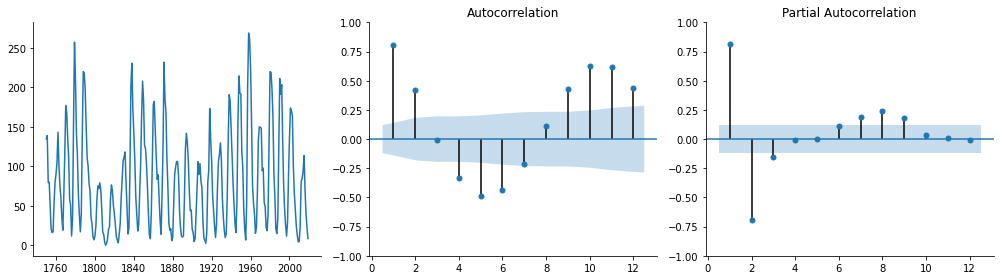

In [13]:
# define helper plot function for visualization
def plots(data, lags=None):
    layout = (1, 3)
    raw  = plt.subplot2grid(layout, (0, 0))
    acf  = plt.subplot2grid(layout, (0, 1))
    pacf = plt.subplot2grid(layout, (0, 2))
    
    raw.plot(data)
    sm.tsa.graphics.plot_acf(data, lags=lags, ax=acf, zero=False)
    sm.tsa.graphics.plot_pacf(data, lags=lags, ax=pacf, zero = False)
    sns.despine()
    plt.tight_layout()

plots(annual_sunspot.sunspots, lags=12);

## Modeling 

### Modeling Objective

We will try with both Time series modeling and Deep Learning.